# Recommendation Systems on IMDB movie dataset

### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [ ]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users in rating df:", num_users)
print("Number of items in rating df:", num_items)
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## 1. Data Preprocessing and Baseline algorithms

### (a) 
Data in recommendation systems is usually encoded as data frame with three or more columns: (user, item, rating, additional meta-data if present). The function dataPreprocessor takes the data frame, total number of users, total number of items and it gives the output a user-item matrix as demonstrated.

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########

    # Initialize a of size (num_users, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [ ]:
dataPreprocessor(rating_df_train, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)
Baseline models

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
              # select the row for user
              # what's the shape of userVector
              userVector = train_matrix[user, :]
              
              # Extract the items the user already rated
              ratedItems = userVector[userVector.nonzero()]
              
              # If not empty, calculate average and set as rating for the current item
              if ratedItems.size == 0:
                  itemAvg = 0
              else:
                  itemAvg = ratedItems.mean()
              predictionMatrix[user, item] = itemAvg
              
          # report progress every 100 users
          if (user % 100 == 0 and item == 1):
              print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))

        for item in range(num_items):
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
              itemPopularity[item] = 0
          else:
              itemPopularity[item] = numOfUsersLiked/numOfUsersRated
      
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          # if rating == 0:
          predictionMatrix[user, item] = itemPopularity[item]
              
          # report progress every 100 users
          if (user % 100 == 0 and item == 1):
              print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df_train, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
x = popularity_recsys.getModel()

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3212.36it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df_train, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3106.02it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## 2. Similarity in Collaborative Filtering

### (a)
In class SimBasedRecSys, there are two similarity measurement functions (cosine, euclidean)

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(1+pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
  
        similarity_matrix = 1/(1+pairwise_distances(matrix, metric='manhattan'))
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########

            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # if k is not None:
            #     uu_similarity = kNearestNeighbor(uu_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model= predictionMatrix 

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            # Initialize the predicted rating matrix with zeros
            train_matrix = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            # if k is not None:
            #     uu_similarity = kNearestNeighbor(uu_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            # predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model= predictionMatrix.T

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

**---- Note ----**

Cosine similarity works best here as from the given array of vectors, all are orthogonal to each other, meaning the angle between them is 90 degress. Moreover from a user item perspective, it suggests 3 users who have watched 1 unique movie of the three. So clearly there must not be any similarity in the users and the same is depicted in cosine metric with a 0, **cosine similarity works the best here**. Moreover it is invatiate to scale of dimensions in the vecotor, since it only cares about the angle


### (b)

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

**---- Note ----**

Using l1 or manhatan distance metric might help here as for high dimensionality, the effects of a few dimension having higher values would be subdued when compared to eucledian where the square of each dimension is taken to calculate the distance.

Reference - 
https://medium.com/@kunal_gohrani/different-types-of-distance-metrics-used-in-machine-learning-e9928c5e26c7#:~:text=Manhattan%20distance%20is%20usually%20preferred,similarity%20between%20two%20data%20points.

## 3. Collaborative Filtering

### (a)
Leveraging the user-user collaborative filtering, implement user-user and item-item based collaborative filtering algorithms

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(rating_df_train, num_users, num_items)
user_cosine_recsys.getModel()

array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3120.37it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df_train, num_users, num_items)
item_cosine_recsys.getModel()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide


array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [ ]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3016.17it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### (b)
class CrossValidation to report comparative RMSE results (averages and  confidence intervals) between user-user and item-item based collaborative  filtering for cosine similarity.

In [ ]:
dclass CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, user_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3050.22it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3076.82it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3085.78it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3094.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 2964.76it/s]


Processing algorithm user-cosine


20000it [00:06, 2875.90it/s]
20000it [00:06, 3076.40it/s]
20000it [00:06, 3110.37it/s]
20000it [00:06, 3067.35it/s]
20000it [00:06, 3021.50it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [ ]:
avg_ratings_per_user = rating_df.groupby('userID').size().to_frame(name='len_ratings')['len_ratings'].mean()
avg_ratings_per_item = rating_df.groupby('itemID').size().to_frame(name='len_ratings')['len_ratings'].mean()

print ('avg. number of ratings per user =', avg_ratings_per_user)
print ('\navg number of ratings per item =', avg_ratings_per_item)

avg. number of ratings per user = 106.04453870625663

avg number of ratings per item = 59.45303210463734


**---- Note ----**

User-cosine RMSE = 1.0173 CI = 1.0090, 1.0256

Item-cosine RMSE = 1.0200 CI = 1.0068, 1.0333


**User based cosine similarity collaborative filtering performed better** (lower RMSE and smaller range of confidence interval) as the number of datapoints available per user were more to take a better informed decision about the missing data points. (avg number of ratings per user = 106.04 and avg number of ratings per item = 59.45).

## 4. Probabilistic Matrix Factorization(PMF)

### (a)

In [ ]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = sqrt(0.1)*np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = sqrt(0.1)*np.random.randn(num_user, self.num_feat)  # user N x D 
    
        ###########         end         ###########

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(self.w_Item[batch_ItemID]*self.w_User[batch_UserID], axis=1) #size (batch_size, )
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[train_item_idx]*self.w_User[train_user_idx], axis=1) # size(pairs_train, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[val_item_idx]*self.w_User[val_user_idx], axis=1) #size(pairs_val, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 17, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

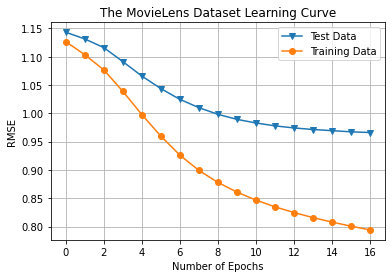

In [ ]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## 5. Performance Comparison

### (a)

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_rprec = CrossValidation('RPrecision')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.

rmse_results = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)
patk_results = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
rprec_results = cv_rprec.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:07, 2846.40it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3084.87it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3125.62it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3084.77it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3070.27it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3075.42it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3123.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3134.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3073.55it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3139.20it/s]


Processing algorithm user-cosine


20000it [00:06, 3040.66it/s]
20000it [00:06, 3108.01it/s]
20000it [00:06, 3111.58it/s]
20000it [00:06, 3093.72it/s]
20000it [00:06, 3052.76it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3035.15it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3065.13it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3118.57it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3084.75it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3076.57it/s]


Processing algorithm PMF


20000it [00:11, 1699.08it/s]
20000it [00:11, 1682.56it/s]
20000it [00:11, 1697.56it/s]
20000it [00:11, 1677.03it/s]
20000it [00:11, 1695.66it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3083.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3047.73it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3074.55it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3074.44it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3115.81it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3105.11it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3079.67it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3133.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3164.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3085.59it/s]


Processing algorithm user-cosine


20000it [00:06, 2975.92it/s]
20000it [00:06, 3098.45it/s]
20000it [00:06, 3200.30it/s]
20000it [00:06, 3169.51it/s]
20000it [00:06, 3130.12it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3093.20it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3062.65it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3089.90it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3065.65it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3018.75it/s]


Processing algorithm PMF


20000it [00:11, 1666.77it/s]
20000it [00:11, 1668.42it/s]
20000it [00:11, 1692.83it/s]
20000it [00:11, 1686.24it/s]
20000it [00:11, 1700.18it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3081.79it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 2980.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3029.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3078.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3105.59it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3079.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3085.97it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3102.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3138.51it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3136.57it/s]


Processing algorithm user-cosine


20000it [00:06, 3104.52it/s]
20000it [00:06, 3100.18it/s]
20000it [00:06, 3032.63it/s]
20000it [00:06, 3095.11it/s]
20000it [00:06, 3069.64it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3105.04it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3074.75it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3097.36it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3093.15it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3103.50it/s]


Processing algorithm PMF


20000it [00:11, 1706.25it/s]
20000it [00:11, 1719.24it/s]
20000it [00:11, 1730.69it/s]
20000it [00:11, 1715.19it/s]
20000it [00:11, 1703.75it/s]


In [ ]:
rmse_results_df = pd.DataFrame(rmse_results, index=['each_fold_rmse', 'mean_rmse', 'min', 'max'])
patk_results_df = pd.DataFrame(patk_results, index=['each_fold_patk', 'mean_patk', 'min', 'max'])
rprec_results_df = pd.DataFrame(rprec_results, index=['each_fold_rprec', 'mean_rprec', 'min', 'max'])

In [ ]:
rmse_results_df

,popularity,useraverage,user-cosine,item-cosine,PMF
each_fold_rmse,"[3.177941281084362, 3.1750480150769977, 3.1474...","[1.0629951276561334, 1.0467467492319966, 1.032...","[1.026449013124381, 1.0214387664779507, 1.0132...","[1.0377631264364244, 1.0207280585350078, 1.010...","[0.9851786271606422, 0.9686605530968466, 0.961..."
mean_rmse,3.15909,1.04372,1.01735,1.02008,0.967591
min,3.13929,1.02893,1.00901,1.00682,0.953404
max,3.17889,1.0585,1.0257,1.03334,0.981777


In [ ]:
patk_results_df

,popularity,useraverage,user-cosine,item-cosine,PMF
each_fold_patk,"[0.36924708377518656, 0.4965005302226948, 0.61...","[0.30604453870625714, 0.4305408271474029, 0.53...","[0.37179215270413657, 0.503923647932133, 0.621...","[0.34316012725344736, 0.483563096500532, 0.602...","[0.36139978791092325, 0.492895015906682, 0.615..."
mean_patk,0.550583,0.473637,0.555843,0.532216,0.545366
min,0.405441,0.341999,0.409598,0.383701,0.39918
max,0.695725,0.605275,0.702088,0.680732,0.691552


In [ ]:
rprec_results_df

,popularity,useraverage,user-cosine,item-cosine,PMF
each_fold_rprec,"[0.7177873723889607, 0.7070154178036713, 0.712...","[0.6403680886295169, 0.6452698039088018, 0.641...","[0.7177834541075783, 0.7127674206396806, 0.715...","[0.6999034077107555, 0.7051212779090774, 0.713...","[0.6969074468574826, 0.6876902522222452, 0.699..."
mean_rprec,0.717666,0.64573,0.721019,0.708014,0.70088
min,0.706824,0.639631,0.709995,0.700692,0.688275
max,0.728509,0.65183,0.732042,0.715336,0.713484


### (b)

**---- Note ----**

1. Popularity baseline cannot be evaluated with RMSE as the predictions of popularity based rec sys is in 0 and 1 while the comparison is between 0-5, hence it would always yield a high RMSE.

2. Useraverage baseline cannot be evaluated with p@k and rprec as the useraverage would give the same user average output for all the unrated items hence rendering the ranked evaluation of p@k and rprec useless

### (c)

**---- Note ----**
1. RMSE = PMF (0.96) is the best as gradient descent is used to minimise the prediction errors
2. P@k = user-cosine (0.55) is the best as it uses the data from the similar users who have rated the item
3. Rprec = user-cosine (0.72) is the best as it uses the data from the similar users who have rated the item 

### (d)

**---- Note ----**

No, high rmse does not imply good performance at p@k or rprec as rmse treats all the retreived recommendations equally while r@p and rprec consider the ranking of the relevant recommendations.

## 6. Similarity Evaluation

### (a)
Go through the list of movies and pick three not-so-popular movies that you know well. I.e., do not choose \Star Wars" and note that we expect everyone in the class to have chosen different movies. For each of these three movies, list the top 5 most similar movie names according to item-item cosine similarity

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

for i in moviesDF.movieTitle.unique():
  print (i)

Toy Story (1995)
GoldenEye (1995)
Four Rooms (1995)
Get Shorty (1995)
Copycat (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Twelve Monkeys (1995)
Babe (1995)
Dead Man Walking (1995)
Richard III (1995)
Seven (Se7en) (1995)
Usual Suspects, The (1995)
Mighty Aphrodite (1995)
Postino, Il (1994)
Mr. Holland's Opus (1995)
French Twist (Gazon maudit) (1995)
From Dusk Till Dawn (1996)
White Balloon, The (1995)
Antonia's Line (1995)
Angels and Insects (1995)
Muppet Treasure Island (1996)
Braveheart (1995)
Taxi Driver (1976)
Rumble in the Bronx (1995)
Birdcage, The (1996)
Brothers McMullen, The (1995)
Bad Boys (1995)
Apollo 13 (1995)
Batman Forever (1995)
Belle de jour (1967)
Crimson Tide (1995)
Crumb (1994)
Desperado (1995)
Doom Generation, The (1995)
Free Willy 2: The Adventure Home (1995)
Mad Love (1995)
Nadja (1994)
Net, The (1995)
Strange Days (1995)
To Wong Foo, Thanks for Everything! Julie Newmar (1995)
Billy Madison (1995)
Clerks (1994)
Disclosure (1994)
Dolores Claiborne (

In [ ]:
def similar_movie(rating_df, num_users, num_items, moviesDF, movie_name, top_k = 5):
  
  # getting the item item similarity
  user_item_matrix = dataPreprocessor(rating_df, num_users, num_items)
  item_user_matrix = user_item_matrix.transpose()
  item_item_similarity = SimBasedRecSys.cosine(item_user_matrix)

  # getting the argument of the movie
  item_id = moviesDF[moviesDF['movieTitle']== movie_name]['movieID'].values[0]

  # getting to similar movies with the item_id
  top_similar_movies_id =  np.argsort(item_item_similarity[item_id-1])[::-1][1:top_k+1]

  print('Searched movie =', movie_name, '\n')
  print('---------- top', top_k, 'movies ----------\n')
  
  for i in top_similar_movies_id:
    top_movies_name = moviesDF[moviesDF['movieID'] == i+1]['movieTitle'].values[0]
    print(top_movies_name)

In [ ]:
similar_movie(rating_df, num_users, num_items, moviesDF, movie_name = 'Hush (1998)', top_k = 5)

Searched movie = Hush (1998) 

---------- top 5 movies ----------

Nightwatch (1997)
Wild Things (1998)
City of Angels (1998)
Man in the Iron Mask, The (1998)
Star Maps (1997)


In [ ]:
similar_movie(rating_df, num_users, num_items, moviesDF, movie_name = 'No Escape (1994)', top_k = 5)

Searched movie = No Escape (1994) 

---------- top 5 movies ----------

Gate of Heavenly Peace, The (1995)
Nemesis 2: Nebula (1995)
Shopping (1994)
Body Parts (1991)
Surviving the Game (1994)


In [ ]:
similar_movie(rating_df, num_users, num_items, moviesDF, movie_name = 'Angel Baby (1995)', top_k = 5)

Searched movie = Angel Baby (1995) 

---------- top 5 movies ----------

Love Serenade (1996)
Mondo (1996)
Designated Mourner, The (1997)
Silence of the Palace, The (Saimt el Qusur) (1994)
Normal Life (1996)


### (b)

**---- Note ----**

The similar movies retreived can be justified even though indirectly they are influenced by the user because a users preferance can depict interest or popularity of the movie of that genre or in that year. The output of the above searches are of similar genre and even the similar time period.

## 7. Testing with different user types

### (a)

In [ ]:
threshold = 50

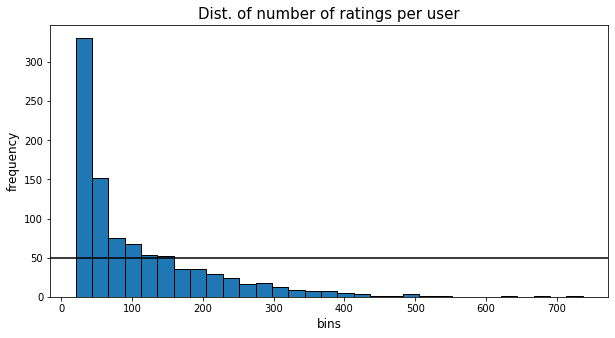

In [ ]:
num_user_rating_df = rating_df.groupby('userID').size().to_frame(name='len_ratings').sort_values(by=['len_ratings'], ascending=False)
plt.figure(figsize=(10,5))
plt.title('Dist. of number of ratings per user', fontsize = 15)
plt.xlabel('bins', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)
plt.hist(num_user_rating_df.len_ratings.values, bins='auto', edgecolor='black', linewidth=1.0)

plt.axhline(y=threshold, color = 'black')

In [ ]:
# choosing userid around threshold
userid_above_thresh = num_user_rating_df[num_user_rating_df.len_ratings >= threshold].index.values
userid_below_thresh = num_user_rating_df[num_user_rating_df.len_ratings < threshold].index.values

# selecting dataframe from above and below
rating_df_train_above_thresh = rating_df_train[rating_df_train.userID.isin(userid_above_thresh)]
rating_df_train_below_thresh = rating_df_train[rating_df_train.userID.isin(userid_below_thresh)]

rating_df_test_above_thresh = rating_df_test[rating_df_test.userID.isin(userid_above_thresh)]
rating_df_test_below_thresh = rating_df_test[rating_df_test.userID.isin(userid_below_thresh)]

In [ ]:
# model generation
user_user_sim_above_thresh_recsys = SimBasedRecSys('user','cosine')
user_user_sim_above_thresh_recsys.predict_all(rating_df_train_above_thresh, num_users, num_items)
user_user_sim_above_thresh_recsys_testdf = user_user_sim_above_thresh_recsys.evaluate_test(rating_df_test_above_thresh)

user_user_sim_below_thresh_recsys = SimBasedRecSys('user','cosine')
user_user_sim_below_thresh_recsys.predict_all(rating_df_train_below_thresh, num_users, num_items)
user_user_sim_below_thresh_recsys_testdf = user_user_sim_below_thresh_recsys.evaluate_test(rating_df_test_below_thresh)

item_item_sim_above_thresh_recsys = SimBasedRecSys('item','cosine')
item_item_sim_above_thresh_recsys.predict_all(rating_df_train_above_thresh, num_users, num_items)
item_item_sim_above_thresh_recsys_testdf = item_item_sim_above_thresh_recsys.evaluate_test(rating_df_test_above_thresh)

item_item_sim_below_thresh_recsys = SimBasedRecSys('item','cosine')
item_item_sim_below_thresh_recsys.predict_all(rating_df_train_below_thresh, num_users, num_items)
item_item_sim_below_thresh_recsys_testdf = item_item_sim_below_thresh_recsys.evaluate_test(rating_df_test_below_thresh)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
18021it [00:06, 2750.68it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value enc

In [ ]:
# ((user_user_sim_above_thresh_recsys_testdf['user-cosine'] - user_user_sim_above_thresh_recsys_testdf['rating']) ** 2).mean() ** .5


rmse_uu_above_t = CrossValidation.rmse(user_user_sim_above_thresh_recsys_testdf, 5, num_users, num_items, pred = 'user-cosine', true='rating')
rmse_uu_below_t = CrossValidation.rmse(user_user_sim_below_thresh_recsys_testdf, 5, num_users, num_items, pred = 'user-cosine', true='rating')
rmse_ii_above_t = CrossValidation.rmse(item_item_sim_above_thresh_recsys_testdf, 5, num_users, num_items, pred = 'item-cosine', true='rating')
rmse_ii_below_t = CrossValidation.rmse(item_item_sim_below_thresh_recsys_testdf, 5, num_users, num_items, pred = 'item-cosine', true='rating')


print('-------------- rmse for all cases for threshold =', threshold ,'--------------\n')
print('UU rmse above threshold =', rmse_uu_above_t)
print('UU rmse below threshold =', rmse_uu_below_t)
print('II rmse above threshold =', rmse_ii_above_t)
print('II rmse below threshold =', rmse_ii_below_t)

-------------- rmse for all cases for threshold = 50 --------------

UU rmse above threshold = 1.0201033029300688
UU rmse below threshold = 1.1756220756956066
II rmse above threshold = 1.0368083032128357
II rmse below threshold = 1.2842247202258927


**---- Note ----**

The threshold chosen was = 50

for user user and item item, the recsys which trained on the users above the threshold frequency performed better than the recsys which trained on the users with below threshold frequency. Since the range of users were less and the data points for each user were more, hence this happened.

Moreover, user user above threshold performs better than item item above threshold as users have more average count of ratings that the items have for average count of users


## 8. Recommender system optimization

In [ ]:
class CompetitionRecSys(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=17, num_batches=10, batch_size=1000):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give  to your competition method
        
        """
        ########## your code goes here ###########
        self.pred_column_name = 'q8_comp_pred'
        ###########         end         ###########

        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        """
                
        ########## your code goes here ###########

        ##################################################### for user - user cosine similarity

        # getting the user - item train matrix nd array UxI
        train_matrix = dataPreprocessor(train_vec, num_user, num_item)

        #getting the similarity matrix
        uu_similarity_matrix = 1 - pairwise_distances(train_matrix, metric='cosine')

        #setting up predection matrix
        temp_matrix = np.zeros(train_matrix.shape)  
        temp_matrix[train_matrix.nonzero()] = 1
        
        #setting up multiplying factor for predictions = normalizer replacing all ones in the pred. matrix with the similarity scores
        normalizer = np.matmul(uu_similarity_matrix, temp_matrix) #UxU (uu_simi) mul UxI(temp_matrix)
        normalizer[normalizer == 0] = 1e-5 # help avoid errors if the normalizer is zero or there is no single similar user for a given user

        # getting the predictions by similarity
        uu_sim_predictionMatrix = np.matmul(uu_similarity_matrix, train_matrix)/normalizer

        # if no one has rated this item before, use user average  
        useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
        columns = np.sum(uu_sim_predictionMatrix, axis=0)
        #print(columns.shape)
        uu_sim_predictionMatrix[:, columns==0] = uu_sim_predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

        self.__modeluusim =  uu_sim_predictionMatrix

        ##################################################### for item - item cosine similarity

        #getting the similarity matrix

        ii_similarity_matrix = 1 - pairwise_distances(train_matrix.T, metric='cosine')

        #setting up predection matrix
        ii_temp_matrix = np.zeros(train_matrix.T.shape)  
        ii_temp_matrix[train_matrix.T.nonzero()] = 1
        
        #setting up multiplying factor for predictions = normalizer replacing all ones in the pred. matrix with the similarity scores
        ii_normalizer = np.matmul(ii_similarity_matrix, ii_temp_matrix) #IxI (ii_simi) mul IxU(temp_matrix)
        ii_normalizer[ii_normalizer == 0] = 1e-5 # help avoid errors if the normalizer is zero or there is no single similar user for a given user

        # getting the predictions by similarity
        ii_sim_predictionMatrix = np.matmul(ii_similarity_matrix, train_matrix.T)/ii_normalizer

        # if no one has rated this item before, use user average  
        ii_useraverage = np.sum(train_matrix.T, axis=1)/np.sum(ii_temp_matrix, axis=1)
        # print(ii_useraverage.shape)
        ii_columns = np.sum(ii_sim_predictionMatrix, axis=0)
        #print(ii_columns.shape)
        ii_sim_predictionMatrix[:, ii_columns==0] = ii_sim_predictionMatrix[:, ii_columns==0] + np.expand_dims(ii_useraverage, axis=1)
        ii_sim_predictionMatrix = ii_sim_predictionMatrix.T

        self.__modeliisim =  ii_sim_predictionMatrix

        ##################################################### for PMF

        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ###########
    
        self.w_Item = sqrt(0.1)*np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = sqrt(0.1)*np.random.randn(num_user, self.num_feat)  # user N x D 
    
        ###########

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(self.w_Item[batch_ItemID]*self.w_User[batch_UserID], axis=1) #size (batch_size, )
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[train_item_idx]*self.w_User[train_user_idx], axis=1) # size(pairs_train, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[val_item_idx]*self.w_User[val_user_idx], axis=1) #size(pairs_val, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        ###########         end         ###########    

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            ########### your code goes here ###########

            # prediction.loc[index, self.pred_column_name] = (0.5*self.__modeluusim[userID-1, itemID-1]) + (0.5*self.__modeliisim[userID-1, itemID-1]) + (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
            # prediction.loc[index, self.pred_column_name] = 0.3333*((np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]) + (0.3333*self.__modeluusim[userID-1, itemID-1]) + (0.3333*self.__modeliisim[userID-1, itemID-1])
            prediction.loc[index, self.pred_column_name] = sum([(np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)], self.__modeluusim[userID-1, itemID-1],  self.__modeliisim[userID-1, itemID-1]])/3
            # prediction.loc[index, self.pred_column_name] = sum([self.__modeluusim[userID-1, itemID-1],  self.__modeliisim[userID-1, itemID-1]])/2
            
            ###########         end         ###########

        return prediction

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 17)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        ########### your code goes here ###########
        self.modeluusim = None
        self.modeliisim = None
        ##########         end         ###########


In [ ]:
competition = CompetitionRecSys()
competition.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 17, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances, num_users, num_items)

Processing algorithm q8_comp_pred


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1673.88it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
20000it [00:12, 1635.97it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1688.47it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1694.83it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
20000it [00:11, 1696.23it/s]


In [ ]:
rp['q8_comp_pred']

[[0.7336167289044186,
  0.7175432024174562,
  0.731489032728469,
  0.7296255169031012,
  0.7378371159304724],
 0.7300223193767834,
 0.7205655198112777,
 0.7394791189422891]

**---- Breif Description ----**

For the approach, an average of predictions were taken of user-cosine recsys, item-cosine recsys and PMF to get the final set of predictions. Also for PMF, l2 regularization was changed to 0.1 with epochs as 17

Final mean rprec = 0.73002

# Validation

In [ ]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [ ]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [ ]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [ ]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [ ]:
validatePMFRecSys(validation_df=validation_df)